In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Data Repository
from ucimlrepo import fetch_ucirepo 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

# Analysis of Worst Case Variants in Geommetry

## Explanation
- Cell 2: Data Exploration and Comparison of Relevant Geommetric Features
- Cell 3: Entropy and Information Gain
- Cell 4: Decision Tree

## Summary:
The analysis of the data in this file is parallel to the analysis in the file `geommetry.ipynb`.

The worst case statistics of tumor cells contain statistics that can be described as "very high numbers". Due to the nature of these statistics as high numbers, the information gain is higher, thus the decision tree has higher confidence for determining the category of a tumor cell.

The highest information gain out of the worst case of geommetry is found in radius (0.6122), followed by concavity (0.4576), which were also the geommetric features with highest information gain in median statistics (0.5183 for radius, 0.5018 for concavity)

Interestingly enough, while in the worst case the information gain from the radius has increased (+0.0939), it has been reduced for the concavity (-0.0442). 


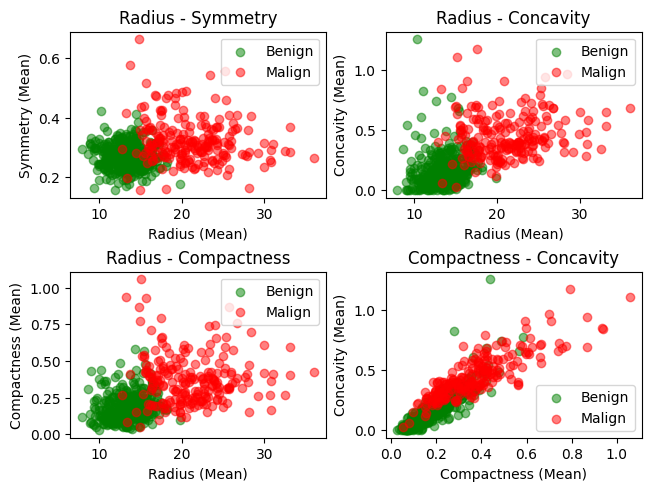

In [2]:
## Block 1: Comparison of geometric features of tumor cells

# Variables
mask = y['Diagnosis'] == 'M'
features = ['radius3', 'compactness3', 'concavity3', 'symmetry3', 'smoothness3']
pairs = [
    ('radius3', 'symmetry3', 'Radius', 'Symmetry'),
    ('radius3', 'concavity3', 'Radius', 'Concavity'),
    ('radius3', 'compactness3', 'Radius', 'Compactness'),
    ('compactness3', 'concavity3', 'Compactness', 'Concavity')
]

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, layout="constrained")

for idx, (feat_x, feat_y, label_x, label_y) in enumerate(pairs):
    row, col = divmod(idx, 2)
    axs[row, col].scatter(X[feat_x][~mask], X[feat_y][~mask], color='green', label='Benign', alpha=0.5)
    axs[row, col].scatter(X[feat_x][mask], X[feat_y][mask], color='red', label='Malign', alpha=0.5)
    axs[row, col].set_xlabel(f'{label_x} (Mean)')
    axs[row, col].set_ylabel(f'{label_y} (Mean)')
    axs[row, col].set_title(f'{label_x} - {label_y}')
    axs[row, col].legend()

plt.show()

In [3]:
## Block 2: Entropy and information gain calculation for comparison of geometric features of tumor cells

def entropy(data, column):
    """
    Entropy = -sum(p_i * log2(p_i))
    """
    value_counts = data[column].value_counts()
    total = len(data)

    ent = 0
    for count in value_counts:
        if count > 0:
            probability = count / total
            ent -= probability * math.log2(probability)
    return ent

def information_gain(X, y, feature, target='Diagnosis', bins=10):
    """
    Information Gain = H(target) - H(target || feature)
    """

    h_target = entropy(y, target)

    combined = pd.DataFrame({
        'feature_binned': pd.cut(X[feature], bins=bins),
        target: y[target]
    })

    h_conditional = 0
    total = len(combined)
    for bin_value, group in combined.groupby('feature_binned', observed=True):
        weight = len(group) / total
        h_conditional += weight * entropy(group, target)

    return h_target - h_conditional

print(f'Baseline Entropy of Diagnosis: {entropy(y, "Diagnosis"):.4f}\n')

for feature in features:
    ig = information_gain(X, y, feature)
    print(f'Information Gain for {feature}: {ig:.4f}')

Baseline Entropy of Diagnosis: 0.9526

Information Gain for radius3: 0.6122
Information Gain for compactness3: 0.2957
Information Gain for concavity3: 0.4576
Information Gain for symmetry3: 0.1363
Information Gain for smoothness3: 0.1488


Accuracy: 0.9591

              precision    recall  f1-score   support

      Benign       0.95      0.99      0.97       108
      Malign       0.98      0.90      0.94        63

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



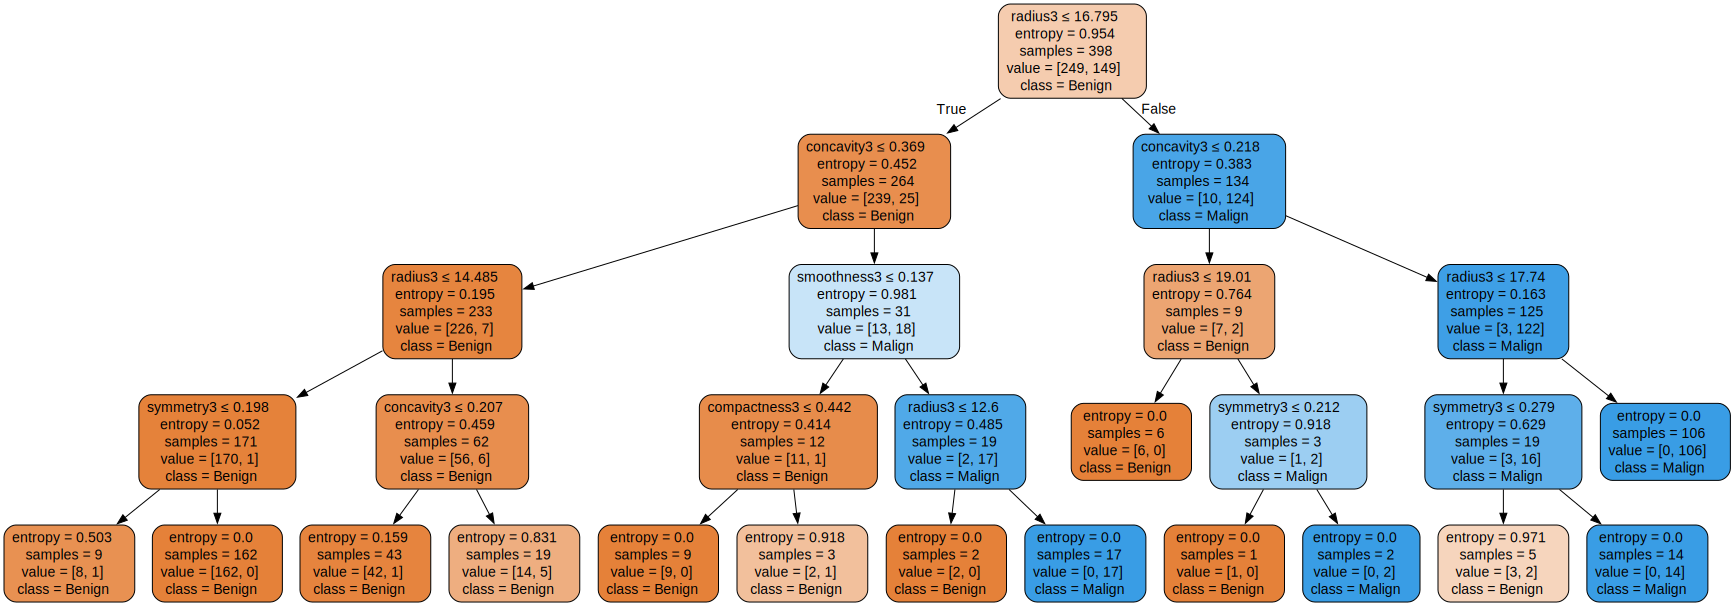

In [4]:
# Block 3: Decision Tree Classifier for geometry

X_selected = X[features]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y['Diagnosis'], test_size=0.3, random_state=42
)

clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=4)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}\n')
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malign']))

dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=features,
    class_names=['Benign', 'Malign'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
display(graph)